In [3]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import sentinelhub as sh

import logging
from datetime import datetime, timedelta
from typing import List, Tuple, Union

import numpy as np
import sentinelhub as sh
from geojson_pydantic import MultiPolygon, Polygon
from pydantic import ValidationError

import json
import shapely
from shapely.geometry import shape, GeometryCollection
from shapely.geometry import Polygon
import rasterio.features

from PIL import Image

from decimal import *

import warnings
# from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

import warnings
warnings.filterwarnings('ignore')

from src.retrivial import ImageRetriever
from src.rasterizeMask import RasterizeMask


In [2]:
sh_client_id = "92cb5d56-56de-45ca-907f-aeefbb571663"
sh_client_secret = "T_TM*-nt|P.t!&bmr0kHv.br:6lC(#f!^y.S-bth"

copernicusFolderPath = "copernicusData/cems-rm-viewer/"
output_folder = "data/"
evalscript = "evalScript.js"

with open(copernicusFolderPath + 'date.json') as json_file:
    dataDict = json.load(json_file)

In [3]:
go = False
smoky_EMSR = ["EMSR369", "EMSR387", "EMSR403", "EMSR408", "EMSR435", "EMSR541", "EMSR571", "EMSR578", "EMSR628", "EMSR632", "EMSR638", "EMSR524",  "EMSR534", "EMSR512", "EMSR545"]

for key, value in dataDict.items():
  if key == "EMSR353": #in smoky_EMSR: #== "EMSR353":
    go = True
  if go:
    EMRS = key
    AOI_list = ["AOI01", "AOI02", "AOI03", "AOI04", "AOI05", "AOI06", "AOI07", "AOI08", "AOI09", "AOI10", "AOI11", "AOI12", "AOI13", "AOI14", "AOI15", "AOI16", "AOI17", "AOI18", "AOI19", "AOI20"]
    # AOI = "AOI01"
    start_date_ESMR = datetime.strptime(dataDict.get(EMRS), "%Y-%m-%dT%H:%M:%S.%f")
    end_date_ESMR = start_date_ESMR + timedelta(days = 30)

    if key in smoky_EMSR:
      start_date_ESMR = start_date_ESMR + timedelta(days = 10)
      end_date_ESMR = start_date_ESMR + timedelta(days = 50)

    for AOI in AOI_list:
      if os.path.exists(copernicusFolderPath + EMRS + "/" + AOI):
        # NO GRADING, ONLY DELINEATION                                     
        if os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/DEL/PRODUCT"):
          print("-------------------------DEL - " + EMRS + " - " + AOI + "-------------------------")
          with open(copernicusFolderPath + EMRS + "/" + AOI + "/DEL/PRODUCT/" + EMRS + "_" + AOI + "_DEL_PRODUCT_areaOfInterestA.json") as f:
            features = json.load(f)["features"]

          polygon_AOI = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features if "type" in list(feature["geometry"]) and feature["geometry"]["type"] == "Polygon"  ]  )
          multipolygon_AOI = shapely.geometry.MultiPolygon(polygon_AOI)

          if len(multipolygon_AOI) == 0:
            print(EMRS + "/" + AOI + " Problemi con Area of Interest -> possibile rings?  ")
            file_object = open('log.txt', 'a')
            file_object.write(EMRS + "/" + AOI + " Problemi con Area of Interest -> possibile rings? \n")
            file_object.close()
            continue

          retr = ImageRetriever(sh_client_id, sh_client_secret)

          files_, acquisition_ = retr.retrieve_images(evalscript=evalscript, 
                                                      data_collection="",
                                                      geometry=multipolygon_AOI, 
                                                      min_dims=(512,512),
                                                      resolution = 10, 
                                                      start_date= start_date_ESMR, 
                                                      end_date=end_date_ESMR,
                                                      cache = True,
                                                      emsr=EMRS + "/" + AOI,
                                                      output_folder = output_folder)

          rasterizer = RasterizeMask(damageLvl = None, copernicusFolderPath = copernicusFolderPath, dateStart = start_date_ESMR, dateEnd = end_date_ESMR)

          rasterizer.rasterizeMaskDelineation(output_folder = output_folder,
                                              ESMR_AOI = EMRS + "/" + AOI + "/", 
                                              files = files_,
                                              RGB=True)
          rasterizer.rasterizeMaskDelineationMerged(output_folder = output_folder,
                                              ESMR_AOI = EMRS + "/" + AOI + "/", 
                                              files = files_,
                                              RGB=True)
          go = False

        # ONLY GRADING, NO DELINEATION
        if os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/GRA/PRODUCT"):
          print("-------------------------GRA - " + EMRS + " - " + AOI + "-------------------------")
          with open(copernicusFolderPath + EMRS + "/" + AOI + "/GRA/PRODUCT/" + EMRS + "_" + AOI + "_GRA_PRODUCT_areaOfInterestA.json") as f:
          # with open(copernicusFolderPath + EMRS + "/" + AOI + "/GRA/PRODUCT/" + EMRS + "_" + AOI + "_GRA_PRODUCT_observedEventA.json") as f:
            features = json.load(f)["features"]
        
          # NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
          polygon_AOI = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features if "type" in list(feature["geometry"]) and feature["geometry"]["type"] == "Polygon"  ]  )
          multipolygon_AOI = shapely.geometry.MultiPolygon(polygon_AOI)

          if len(multipolygon_AOI) == 0:
            print(EMRS + "/" + AOI + " Problemi con Area of Interest -> possibile rings?  ")
            file_object = open('log.txt', 'a')
            file_object.write(EMRS + "/" + AOI + " Problemi con Area of Interest -> possibile rings? \n")
            file_object.close()
            continue

          retr = ImageRetriever(sh_client_id, sh_client_secret)

          files_, acquisition_ = retr.retrieve_images(evalscript=evalscript, 
                                                      data_collection="",
                                                      geometry=multipolygon_AOI, 
                                                      min_dims=(512,512),
                                                      resolution = 10, 
                                                      start_date= start_date_ESMR, 
                                                      end_date=end_date_ESMR,
                                                      cache = True,
                                                      emsr=EMRS + "/" + AOI,
                                                      output_folder = output_folder)
          if files_ is None:
            go = False
            continue

          rasterizer = RasterizeMask(damageLvl = None, copernicusFolderPath = copernicusFolderPath, dateStart = start_date_ESMR, dateEnd = end_date_ESMR)

          multipolygon = []
          multipolygon = rasterizer.multipolygonGrading(ESMR_AOI = EMRS + "/" + AOI + "/")

          if multipolygon is None:
            print(EMRS + "/" + AOI + " GRA TypeError: object of type 'NoneType'  ")
            file_object = open('log.txt', 'a')
            file_object.write(EMRS + "/" + AOI + " GRA multipolygon -> TypeError: object of type 'NoneType' \n")
            file_object.close()
            continue

          if len(multipolygon) == 0:
            file_object = open('log.txt', 'a')
            file_object.write(EMRS + "/" + AOI + " - GRA Multipolygon len = 0 \n")
            file_object.close()
            continue

          rasterizer.rasterizeMaskGrading(ESMR_dataPath = output_folder + EMRS + "/" + AOI + "/", 
                                          multipolygon = multipolygon, 
                                          files = files_, 
                                          RGB=True)
          rasterizer.rasterizeMaskGradingMerged(ESMR_dataPath = output_folder + EMRS + "/" + AOI + "/", 
                                              multipolygon = multipolygon, 
                                              files = files_, 
                                              RGB=True)
          go = False

        # ONLY FEP
        if os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/FEP/PRODUCT") and \
           not os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/GRA/PRODUCT") and \
           not os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/DEL/PRODUCT"):
          print("-------------------------FEP - " + EMRS + " - " + AOI + "-------------------------")
          with open(copernicusFolderPath + EMRS + "/" + AOI + "/FEP/PRODUCT/" + EMRS + "_" + AOI + "_FEP_PRODUCT_areaOfInterestA.json") as f:
            features = json.load(f)["features"]
        
          # NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
          polygon_AOI = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features if "type" in list(feature["geometry"]) and feature["geometry"]["type"] == "Polygon"  ]  )
          multipolygon_AOI = shapely.geometry.MultiPolygon(polygon_AOI)

          if len(multipolygon_AOI) == 0:
            print(EMRS + "/" + AOI + " Problemi con Area of Interest -> possibile rings?  ")
            file_object = open('log.txt', 'a')
            file_object.write(EMRS + "/" + AOI + " Problemi con Area of Interest -> possibile rings? \n")
            file_object.close()
            continue

          retr = ImageRetriever(sh_client_id, sh_client_secret)

          files_, acquisition_ = retr.retrieve_images(evalscript=evalscript, 
                                                      data_collection="",
                                                      geometry=multipolygon_AOI, 
                                                      min_dims=(512,512),
                                                      resolution = 10, 
                                                      start_date= start_date_ESMR, 
                                                      end_date=end_date_ESMR,
                                                      cache = True,
                                                      emsr=EMRS + "/" + AOI,
                                                      output_folder = output_folder + "dataSuboptimal/FEP/")
          if files_ is None:
            go = False
            continue

          rasterizer = RasterizeMask(damageLvl = None, copernicusFolderPath = copernicusFolderPath, dateStart = start_date_ESMR, dateEnd = end_date_ESMR)

          rasterizer.rasterizeMaskFEP(output_folder = output_folder + "dataSuboptimal/FEP/",
                                              ESMR_AOI = EMRS + "/" + AOI + "/", 
                                              files = files_,
                                              RGB=True)
          rasterizer.rasterizeMaskFEPMerged(output_folder = output_folder + "dataSuboptimal/FEP/",
                                              ESMR_AOI = EMRS + "/" + AOI + "/", 
                                              files = files_,
                                              RGB=True)
          go = False

        if not os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/GRA/PRODUCT") and \
           not os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/DEL/PRODUCT") and \
           not os.path.exists(copernicusFolderPath + EMRS + "/" + AOI + "/FEP/PRODUCT"):
          print("====================================" + EMRS + AOI + "===================================== No DEL, GRA or FEP file found")
          file_object = open('log.txt', 'a')
          file_object.write(EMRS + "/" + AOI + " - No DEL, GRA or FEP file found \n")
          file_object.close()
          go = False
          continue

-------------------------DEL - EMSR353 - AOI01-------------------------


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


-------------------------GRA - EMSR353 - AOI01-------------------------


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [2]:
# 15 decimals precision
getcontext().prec = 20

#Creation CSV
input_folder = "data/"
file = ""
open('satellite_dataNEW.csv', 'w').close() #clean the file
file_object = open('satellite_dataNEW.csv', 'a')
file_object.write("EMSR,AOI,type,folder,folderPath,activationDate,interval_startDate,interval_endDate,left_Long,bottom_Lat,right_Long,top_Lat,\
                    centerBoxLong,centerBoxLat,height,width,resolution_x,resolution_y\n")
file_object.close()

for dirpath, dirnames, filenames in os.walk(input_folder):
    # GRADING
    for filename in [f for f in filenames if "GRA_DamageMask.png" in f]:
        if "dataSuboptimal" in dirpath.split('/'):
            if "cloudy" in dirpath.split('/'):
                optimal = "subOptimal_cloudy"
            if "cloudyClean" in dirpath.split('/'):
                optimal = "subOptimal_cloudyClean"
            if "smoke" in dirpath.split('/'):
                optimal = "subOptimal_smoke"
            
            EMSR = dirpath.split('/')[3]
            AOI = dirpath.split('/')[4]
        else:
            optimal = "optimal"

            EMSR = dirpath.split('/')[1]
            AOI = dirpath.split('/')[2]

        if(os.path.isdir(dirpath)):
            file = dirpath + "/request.json"
            tif_path = dirpath + "/response.tiff"
            
        bbox = np.zeros(4)
        with rasterio.open(tif_path) as tif_image:
            resolution_x = Decimal(tif_image.meta.get("transform")[0])
            resolution_y = Decimal(tif_image.meta.get("transform")[4])
            bbox[0] = Decimal(tif_image.profile["transform"][2])
            bbox[1] = Decimal(tif_image.profile["transform"][5]) - (Decimal(tif_image.profile["height"]) * Decimal(abs(tif_image.profile["transform"][4])))
            bbox[2] = Decimal(tif_image.profile["transform"][2]) + (Decimal(tif_image.profile["width"]) * Decimal(abs(tif_image.profile["transform"][0])))
            bbox[3] = Decimal(tif_image.profile["transform"][5])

        with open("copernicusData/cems-rm-viewer/date.json") as json_date:
            dataDict = json.load(json_date)
            activationDate = dataDict.get(EMSR)

        with open(file) as f:
            json_file = json.load(f)
            payload = json_file["payload"]
            # bbox = payload["input"]["bounds"]["bbox"]
            # if(len(bbox)>4):
            #     print("Problemaaaaaaaaaaaa")
            startDate = payload["input"]["data"][0]["dataFilter"]["timeRange"]["from"]
            endDate = payload["input"]["data"][0]["dataFilter"]["timeRange"]["to"]
            height = payload["output"]["height"]
            width = payload["output"]["width"]

            CSV_line = str(EMSR) + "," + str(AOI) + ",GRA," + optimal + "," + str(dirpath) + "," + str(activationDate) + "," \
                + str(startDate) + "," + str(endDate) + "," + str(Decimal(bbox[0])) + "," + str(Decimal(bbox[1])) + "," \
                + str(Decimal(bbox[2])) + "," + str(Decimal(bbox[3])) + "," + str((Decimal(bbox[0])+Decimal(bbox[2]))/2) + "," \
                + str((Decimal(bbox[1])+Decimal(bbox[3]))/2) + "," + str(height) + "," + str(width) + "," + str(resolution_x) + "," + str(resolution_y) + "\n"

            file_object = open('satellite_dataNEW.csv', 'a')
            file_object.write(CSV_line)
            file_object.close()
    
    # DELINATION
    for filename in [f for f in filenames if "DEL_DelineationMask.png" in f]:
        if "dataSuboptimal" in dirpath.split('/'):
            if "cloudy" in dirpath.split('/'):
                optimal = "subOptimal_cloudy"
            if "cloudyClean" in dirpath.split('/'):
                optimal = "subOptimal_cloudyClean"
            if "smoke" in dirpath.split('/'):
                optimal = "subOptimal_smoke"
            
            EMSR = dirpath.split('/')[3]
            AOI = dirpath.split('/')[4]
        else:
            optimal = "optimal"

            EMSR = dirpath.split('/')[1]
            AOI = dirpath.split('/')[2]

        if(os.path.isdir(dirpath)):
            file = dirpath + "/request.json"
            tif_path = dirpath + "/response.tiff"
            
        bbox = np.zeros(4)
        with rasterio.open(tif_path) as tif_image:
            resolution_x = Decimal(tif_image.meta.get("transform")[0])
            resolution_y = Decimal(tif_image.meta.get("transform")[4])
            bbox[0] = Decimal(tif_image.profile["transform"][2])
            bbox[1] = Decimal(tif_image.profile["transform"][5]) - (Decimal(tif_image.profile["height"]) * Decimal(abs(tif_image.profile["transform"][4]))) 
            bbox[2] = Decimal(tif_image.profile["transform"][2]) + (Decimal(tif_image.profile["width"]) * Decimal(abs(tif_image.profile["transform"][0])))
            bbox[3] = Decimal(tif_image.profile["transform"][5])

        with open("copernicusData/cems-rm-viewer/date.json") as json_date:
            dataDict = json.load(json_date)
            activationDate = dataDict.get(EMSR)

        with open(file) as f:
            json_file = json.load(f)
            payload = json_file["payload"]
            # bbox= payload["input"]["bounds"]["bbox"]
            # if(len(bbox)>4):
            #     print("Problemaaaaaaaaaaaa")
            startDate = payload["input"]["data"][0]["dataFilter"]["timeRange"]["from"]
            endDate = payload["input"]["data"][0]["dataFilter"]["timeRange"]["to"]
            height = payload["output"]["height"]
            width = payload["output"]["width"]

            CSV_line = str(EMSR) + "," + str(AOI) + ",DEL," + optimal + "," + str(dirpath) + "," + str(activationDate) + "," \
                + str(startDate) + "," + str(endDate) + "," + str(Decimal(bbox[0])) + "," + str(Decimal(bbox[1])) + "," \
                + str(Decimal(bbox[2])) + "," + str(Decimal(bbox[3])) + "," + str((Decimal(bbox[0])+Decimal(bbox[2]))/2) + "," \
                + str((Decimal(bbox[1])+Decimal(bbox[3]))/2) + "," + str(height) + "," + str(width) + "," + str(resolution_x) + "," + str(resolution_y) + "\n"

            file_object = open('satellite_dataNEW.csv', 'a')
            file_object.write(CSV_line)
            file_object.close()

    # FEP Estimation
    for filename in [f for f in filenames if "FEP_EstimationMask.png" in f]:
        if "dataSuboptimal" in dirpath.split('/'):
            optimal = "subOptimal_FEP"
            
            EMSR = dirpath.split('/')[3]
            AOI = dirpath.split('/')[4]
        else:
            continue

        if(os.path.isdir(dirpath)):
            file = dirpath + "/request.json"
            tif_path = dirpath + "/response.tiff"
        
        bbox = np.zeros(4)
        with rasterio.open(tif_path) as tif_image:
            resolution_x = Decimal(tif_image.meta.get("transform")[0])
            resolution_y = Decimal(tif_image.meta.get("transform")[4])
            bbox[0] = Decimal(tif_image.profile["transform"][2])
            bbox[1] = Decimal(tif_image.profile["transform"][5]) - (Decimal(tif_image.profile["height"]) * Decimal(abs(tif_image.profile["transform"][4]))) 
            bbox[2] = Decimal(tif_image.profile["transform"][2]) + (Decimal(tif_image.profile["width"]) * Decimal(abs(tif_image.profile["transform"][0])))
            bbox[3] = Decimal(tif_image.profile["transform"][5])

        with open("copernicusData/cems-rm-viewer/date.json") as json_date:
            dataDict = json.load(json_date)
            activationDate = dataDict.get(EMSR)

        with open(file) as f:
            json_file = json.load(f)
            payload = json_file["payload"]
            # bbox = payload["input"]["bounds"]["bbox"]
            # if(len(bbox)>4):
            #     print("Problemaaaaaaaaaaaa")
            startDate = payload["input"]["data"][0]["dataFilter"]["timeRange"]["from"]
            endDate = payload["input"]["data"][0]["dataFilter"]["timeRange"]["to"]
            height = payload["output"]["height"]
            width = payload["output"]["width"]

            CSV_line = str(EMSR) + "," + str(AOI) + ",FEP," + optimal + "," + str(dirpath) + "," + str(activationDate) + "," \
                + str(startDate) + "," + str(endDate) + "," + str(Decimal(bbox[0])) + "," + str(Decimal(bbox[1])) + "," \
                + str(Decimal(bbox[2])) + "," + str(Decimal(bbox[3])) + "," + str((Decimal(bbox[0])+Decimal(bbox[2]))/2) + "," \
                + str((Decimal(bbox[1])+Decimal(bbox[3]))/2) + "," + str(height) + "," + str(width)  + "," + str(resolution_x) + "," + str(resolution_y) + "\n"
            
            file_object = open('satellite_dataNEW.csv', 'a')
            file_object.write(CSV_line)
            file_object.close()

# #Sort and order the data
df = pd.read_csv('satellite_dataNEW.csv', float_precision='round_trip')
open('satellite_dataNEW.csv', 'w').close() #clean the file
file_object = open('satellite_dataNEW.csv', 'a')
file_object.write("EMSR,AOI,type,folder,folderPath,activationDate,interval_startDate,interval_endDate,left_Long,bottom_Lat,right_Long,top_Lat,centerBoxLong,centerBoxLat,height,width,resolution_x,resolution_y\n")
file_object.close()
df = df.sort_values(['EMSR', 'AOI'], ascending = [True, True])
df.to_csv('satellite_dataNEW.csv', mode='a', index=False, header=False, float_format='%.20f')


# EMSR, AOI, pathFolder, activationDate, acquisitionDate, startDate, endDate, top_left_long, top_left_lat, 
# bottom_right_long, bottom_right_lat, centerLong, centerLat, width, height,

In [26]:
#Creation CSV Preconfigured
input_folder = "data/"
file = ""

open('datasetPreConfigured.csv', 'w').close() #clean the file
file_object = open('datasetPreConfigured.csv', 'a')
file_object.write("EMSR,AOI,folderType,folderPath,activationDate,suggested_startDate,suggested_endDate\n")
file_object.close()

df = pd.read_csv('satellite_dataNEW.csv')
df = df.drop(columns=["GRA","DEL","FEP", "left_Long", "bottom_Lat", "right_Long", "top_Lat", "centerBoxLong", "centerBoxLat", "height", "width", "resolution_x", "resolution_y"])

df["folderPath"] = df["folderPath"].apply(lambda pathFolder: "/".join(pathFolder.split("/")[:3]) if pathFolder.split("/")[1] == "dataSuboptimal" else pathFolder.split("/")[0])
df["folderPath"] = df["folderPath"].apply(lambda pathFolder: pathFolder+"/")
# df = df.groupby(["EMSR", "AOI"], as_index = False)
df = df.drop_duplicates()

df = df.sort_values(['EMSR', 'AOI'], ascending = [True, True])
df.to_csv('datasetPreConfigured.csv', mode='a', index=False, header=False)

In [ ]:
#Save all tiff in RGB 
input_folder = "data/"

# for dirpath, dirnames, filenames in os.walk(input_folder):
#     for filename in [f for f in filenames if "response.tiff" in f]:
#         print(dirpath)
#         with rasterio.open(dirpath + "/response.tiff") as tif_image:
            
#             image_np = tif_image.read()
#             image_np = np.transpose(image_np, (1, 2, 0))
#             factor = 10000/255*3.5*5,
#             im = Image.fromarray( np.multiply(image_np[:,:,[3,2,1]],factor).astype(np.uint8) )
#             im.save(dirpath + "/response.png")

# for dirpath, dirnames, filenames in os.walk(input_folder):
#     for filename in [f for f in filenames if "response_merged.tif" in f]:
#         print(dirpath)
#         with rasterio.open(dirpath + "/response_merged.tif") as tif_image:
#             image_np = tif_image.read()
#             image_np = np.transpose(image_np, (1, 2, 0))
#             factor = 10000/255*3.5*5,
#             im = Image.fromarray( np.multiply(image_np[:,:,[3,2,1]],factor).astype(np.uint8) )
#             im.save(dirpath + "/response_merged.png")


import os
import shutil

for root, dirs, files in os.walk(input_folder):  # replace the . with your starting directory
    for file in files:
        if file == "response_merged.png" or file == "DEL_DelineationMask_merged.png" or file == "GRA_DamageMask_merged.png" or file == "FEP_EstimationMask_merged.png" or \
           file == "response.png" or file == "DEL_DelineationMask.png" or file == "GRA_DamageMask.png" or file == "FEP_EstimationMask.png":
            # print(root)
            
            path_file = os.path.join(root,file)
            path_dest = root.replace("data/","RGB/")
            # print(path_dest)
            if not os.path.isdir(path_dest):
                os.makedirs(path_dest)

            shutil.copy2(path_file, path_dest) # change you destination dir
            

In [ ]:
import cloudsen12

class CloudCover:
    def __init__(self, cropsize: int, overlap: int):
        self.cloudBands = ["Aerosol", "Blue", "Green", "Red", "RedEdge1", "RedEdge2", "RedEdge3", "NIR", "NIR2", "WaterVapor", "SWIR1", "SWIR2"]
        
        self.cloud_model = cloudsen12.UnetMobV2()
        self.cloud_predictor = cloudsen12.Predictor(
            cropsize = cropsize,
            overlap = overlap,
            device = "cpu",
            quiet = True
        )

    def predictCover(self, image: np.ndarray):

        cirrus = np.full((image.shape[1], image.shape[2]), 0.0001)
        image = np.nan_to_num(image)
        print(image.shape)
        cloud_bands_dict = {"Cirrus" : cirrus}
        for i, band in enumerate(self.cloudBands):
            cloud_bands_dict[band] = image[i] #image[:,:, i]
        
        cloud_tensor = cloudsen12.TensorSat(**cloud_bands_dict, cache=True, align=False)

        result = self.cloud_predictor.predict(self.cloud_model, cloud_tensor)
        return result
    

In [ ]:

with rasterio.open("data/EMSR382/AOI01/4d0375848c84bea1d5545d0ed4d60ca7/response.tiff") as image:
    # print(image.profile)
    cloudCov = CloudCover(512, 0)
    
    # image512 = image.read()
    result = cloudCov.predictCover(image.read()*10000) #image512[:,:512,:512]*10000)
    resultMask = result[1] > 7500
    print(result.shape)
    out_meta = image.meta

    out_meta.update(
        {   
            # "height": 512,
            # "width": 512,
            "count": 4, #salvo solo un livello per maschera
            "dtype": rasterio.uint16
        }
    )

    out_metaMask = image.meta

    out_metaMask.update(
        {   
            # "height": 512,
            # "width": 512,
            "count": 1, #salvo solo un livello per maschera
            "dtype": rasterio.uint8,
        }
    )

with rasterio.open("responseCloud.tif", "w", **out_meta) as dest:
    dest.write(result)
with rasterio.open("responseCloudMask.tif", "w", **out_metaMask) as dest:
    dest.write(np.expand_dims(resultMask, axis=0))

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(12, 1380, 1129)
(4, 1380, 1129)


In [ ]:
def plot_image(image, factor=1.0, clip_range=None, nrows=1, ncols=1, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk("data") for f in filenames if os.path.splitext(f)[1] == '.tiff']

In [ ]:
im = []
for num in range(len(images)):
    im.append(io.imread(images[num]))

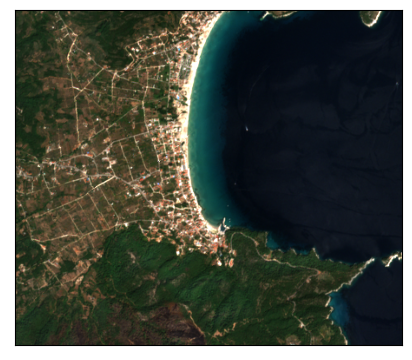

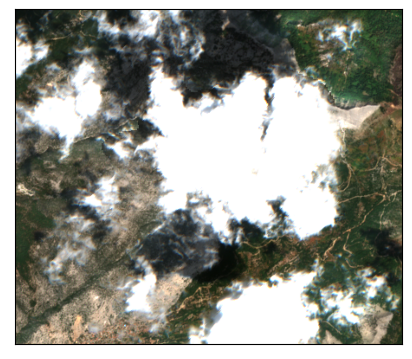

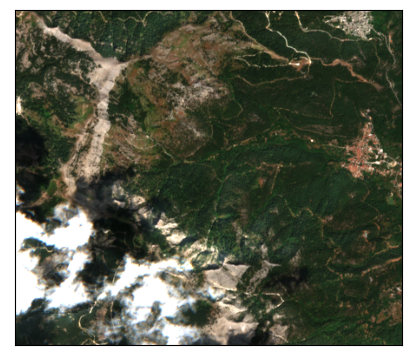

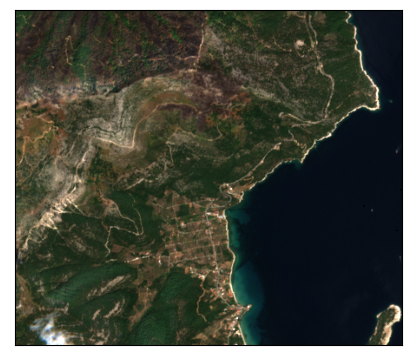

In [ ]:
for image in im:
    plot_image(image[:,:,[3,2,1]], factor=3.5, clip_range=(0,1)) #, nrows=1, ncols=1)

In [ ]:
#transform  epsg https://gis.stackexchange.com/questions/346181/project-large-collection-of-shapely-object-to-different-crs
def convertCoordinates(polygons):
    #trnasform epsg:4326 -> epsg3857
    transformer = pyproj.Transformer.from_proj(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init='epsg:3857'))
    polygons_reprojected = []
    for polygon in polygons:
        polygons_reprojected.append(shapely.ops.transform(transformer.transform, polygon))
    return polygons_reprojected

In [19]:
import rasterio

def get_koppen_label(lon, lat, tif_file):
    """
    Given the coordinates of a location, return the relative koppen labels of the location
    
    Map downloaded from: https://figshare.com/articles/dataset/Present_and_future_K_ppen-Geiger_climate_classification_maps_at_1-km_resolution/6396959/2
    """
    with rasterio.open(tif_file) as src:
        row, col = src.index(lon, lat)
        value = src.read(1, window=((row, row+1), (col, col+1)))
        print(value)
        return value[0][0]

kmz_file_path = "assets/koppen_climate/koppen_climate.tif"
lat = 45
long = 8

info = get_koppen_label(long, lat, kmz_file_path)
print(info)

koppen_dict = { 1:  "Af", 2:  "Am", 3:  "Aw", 4:  "BWh", 5:  "BWk", 6:  "BSh", 7:  "BSk", 8:  "Csa", 9:  "Csb", 10: "Csc", 11: "Cwa", 12: "Cwb", 13: "Cwc", 14: "Cfa", 
               15: "Cfb", 16: "Cfc", 17: "Dsa", 18: "Dsb", 19: "Dsc", 20: "Dsd", 21: "Dwa", 22: "Dwb", 23: "Dwc", 24: "Dwd", 25: "Dfa", 26: "Dfb", 27: "Dfc", 
               28: "Dfd", 29: "ET", 30: "EF" }
print(koppen_dict[info])
# if info is not None:
#     print(info)
# else:
#     print('No information found at this location.')

[[14]]
14
Cfa
